<a href="https://colab.research.google.com/github/erickbonas/projetofinal/blob/main/tfidf_n_gramas_smoteen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baixando Arquivos (Colab)

In [48]:
from google.colab import files
files.upload()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


     |█████▋                          | 10kB 19.8MB/s eta 0:00:01
     |███████████▎                    | 20kB 26.1MB/s eta 0:00:01
     |█████████████████               | 30kB 22.1MB/s eta 0:00:01
     |██████████████████████▌         | 40kB 17.0MB/s eta 0:00:01
     |████████████████████████████▏   | 51kB 8.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 4.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp37-none-any.whl size=72858 sha256=5ddaea16c84e874b7402f7370c6ff55a67c87425a6729e59e7c8177d74cfbd3b
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
! mkdir dataset

In [ ]:
! kaggle competitions download -c fake-news-pair-classification-challenge -p '/content/dataset'

 26% 9.00M/34.6M [00:00<00:00, 33.1MB/s]
100% 34.6M/34.6M [00:00<00:00, 93.6MB/s]


In [ ]:
! unzip '/content/dataset/fake-news-pair-classification-challenge.zip' -d '/content/dataset'

Archive:  /content/dataset/fake-news-pair-classification-challenge.zip
  inflating: /content/dataset/sample_submission.csv  
  inflating: /content/dataset/test.csv  
  inflating: /content/dataset/train.csv  


# Imports e definição de funções

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.combine import SMOTEENN
from sklearn import metrics
import seaborn as sns; sns.set()
np.random.seed(1082141) 

In [2]:
def evaluate(y, p, probabilities, labels=None):
    # Cálculo das métricas de acerto.
    print('Accuracy:', metrics.accuracy_score(y, p).round(3))
    print('Accuracy (balanced):', metrics.balanced_accuracy_score(y, p).round(3))
    
    # Calculo da matriz de confusão.
    c = metrics.confusion_matrix(y, p)
    r = c / c.sum(axis=1, keepdims=True)
    
    # Impressão dos gráficos.
    (plt
     .figure(figsize=(10, 8))
     .suptitle('Matriz de confusão', fontsize=20))
    sns.heatmap(r,
                cmap="YlGnBu", linewidths=.5, annot=True, fmt=".1%",
                xticklabels=labels, yticklabels=labels, cbar=False)   

# Carregando a base 

In [3]:
training = pd.read_csv('dataset/train.csv')
training = training.sample(n=1000)
training.head()

,id,tid1,tid2,title1_zh,title2_zh,title1_en,title2_en,label
211932,212355,131802,131812,晚上泡脚往水里丢一小把，能逼出20年湿毒，腰细了，肚子也平了,洗脚水里丢一小把“它”，20年湿毒轻松逼出！腰细了，肚子也平了,"Foot in the water in the evening a small drop,...","A little ""it"" in the washing water, 20-year-ol...",agreed
312807,313438,165062,80104,舌是“心之苗”，舌头发青就是癌症信号？,包头人注意了！此处发青，是癌症早期信号！,"The tongue is the heart seedling, the tongue i...",Baotou people pay attention! This place is gre...,unrelated
306723,307351,159590,163192,肚子一把肉，懒人1招减肥瘦肚腩，坚持一月瘦20斤！,2分钟办公室减肥方法大曝光，3个动作助你月月瘦10斤,"Belly a meat, lazy one to reduce weight loss, ...","2 Minutes Office Weight Loss Method, 3 moves t...",unrelated
319858,320494,155330,94967,莫让“轻度高血压”让你减寿十几年,高血压减寿20年？过于夸张，不过患者寿命确实受影响,Don't let '' mild blood pressure '' kill you f...,"Hypertension is 20 years old? Hyperbole, but l...",unrelated
87536,87800,67748,69834,农村扶贫政策重大调整，贫困农民可以领到这些补贴了,最佳“水果时间表”，这样吃最助于减肥！,Major readjustments in poverty alleviation pol...,"The best ""fruit timetable"", this eating most h...",unrelated


In [4]:
#Aplica strip em todas as colunas do dataframe
training = training.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

In [5]:
training = training.replace(r'^\s*$', np.nan, regex=True)

In [6]:
# Remove todos os NaN da tabela
training = training.dropna()

# Separação da base em treino e validação

In [9]:
df_train, df_val = train_test_split(training[['title1_en', 'title2_en', 'label']], test_size=0.2, shuffle=True)
df_train.head(3)


,title1_en,title2_en,label
255411,"His parents are like Pan Changjiang, but the s...",RUMORS: Children with asthma can't play sports.,unrelated
141679,Tin Hing Wang Fei Drug Abuse? Wong Yi-qing mic...,How to do the old shoe? Don't be silly with 50...,unrelated
110288,"Kappero has resigned from jiangsu's suunin, an...",Rumors: Yang Xu's possibility to transfer to S...,unrelated


In [10]:
x_train, x_val = df_train[['title1_en', 'title2_en']], df_val[['title1_en', 'title2_en']]
y_train, y_val = df_train['label'], df_val['label']
x_val.head(3)

,title1_en,title2_en
14424,"A 40 -year-old man with kidney asthenia, eatin...","This thing is strong, cancer prevention is a t..."
298363,"Who owns a billion Dollar Mansion? Today, the ...",HK $200 million in HK $200 million buy Zhang L...
31721,"""The People's Name 2"" Shoots, Male Shift's Cha...","""The People's Name 2"" begins, the cast is expo..."


# Teste com ngram e smoteenn

Realização de testes usando o parametro ngram_rang do TfidfVectorizer e depois aplicamos a função SMOTEENN para balancear o conjunto de features

## Criando a matriz td-idf com ngram_range=(1,3)

In [ ]:
features = 200

encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',                                        
                                        ngram_range=(1,3),
                                        max_features=features),                                        
                        StandardScaler(with_mean=False))

x_train_title1 = encoder.fit_transform(x_train['title1_en']).toarray()
x_val_title1 = encoder.transform(x_val['title1_en']).toarray()

x_train_title2 = encoder.fit_transform(x_train['title2_en']).toarray()
x_val_title2 = encoder.transform(x_val['title2_en']).toarray()

In [ ]:
label_enc = LabelEncoder()
ye_train = label_enc.fit_transform(y_train)
ye_val = label_enc.transform(y_val)

In [ ]:
label_enc.classes_

array(['agreed', 'disagreed', 'unrelated'], dtype=object)

In [ ]:
x_train = np.concatenate((x_train_title1, x_train_title2), axis=1)
x_val = np.concatenate((x_val_title1, x_val_title2), axis=1)

In [ ]:
x_train.shape

(16000, 400)

In [ ]:
y_train.shape

(16000,)

## Teste com o regressor logistico

In [ ]:
C_range = np.logspace(-3, 2, 5)

lm = LogisticRegression(multi_class='ovr', solver='liblinear', max_iter=200, class_weight='balanced')

grid_values = {'penalty': ['l1','l2'], 'C': C_range}
grid_lm = GridSearchCV(lm, param_grid = grid_values, cv=3, scoring = 'accuracy', n_jobs = -1)

grid_lm.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=200, multi_class='ovr',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.77827941e-02, 3.16227766e-01, 5.62341325e+00,
       1.00000000e+02]),
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
C_best = grid_lm.best_params_['C']
penalty_best = grid_lm.best_params_['penalty']
g = grid_lm 


In [ ]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_lm.best_params_, grid_lm.best_score_))

Melhores parametros encontrados {'C': 0.001, 'penalty': 'l1'} com score de 0.6807


Accuracy: 0.668
Accuracy (balanced): 0.37


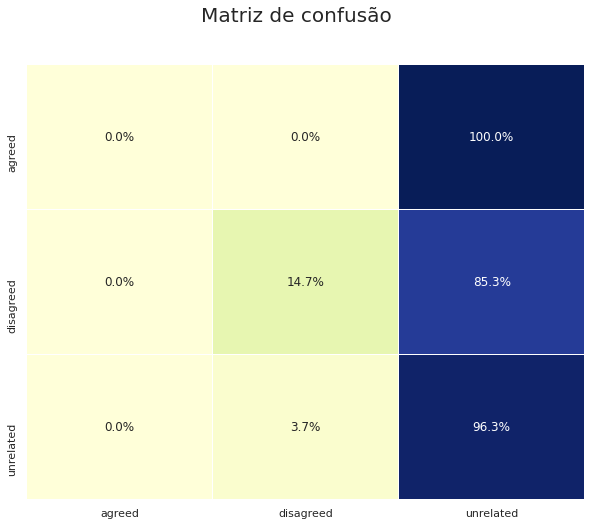

In [ ]:
evaluate(y_val, g.predict(x_val), g.predict_proba(x_val), labels=label_enc.classes_)

## Teste com RandomForest

In [ ]:
# Random Forest
clf = RandomForestClassifier(      
    oob_score=True, 
    n_jobs=-1, 
    class_weight='balanced', 
    max_features=features
)

grid_clf_values = {'max_depth': [5, 10, 15], 'n_estimators': [100]}
grid_clf = GridSearchCV(clf, param_grid = grid_clf_values, cv=3, scoring = 'balanced_accuracy', n_jobs = -1)

grid_clf.fit(x_train, y_train)

In [ ]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_clf.best_params_, grid_clf.best_score_))

Melhores parametros encontrados {'max_depth': 15, 'n_estimators': 200} com score de 0.4199


Accuracy: 0.342
Accuracy (balanced): 0.428


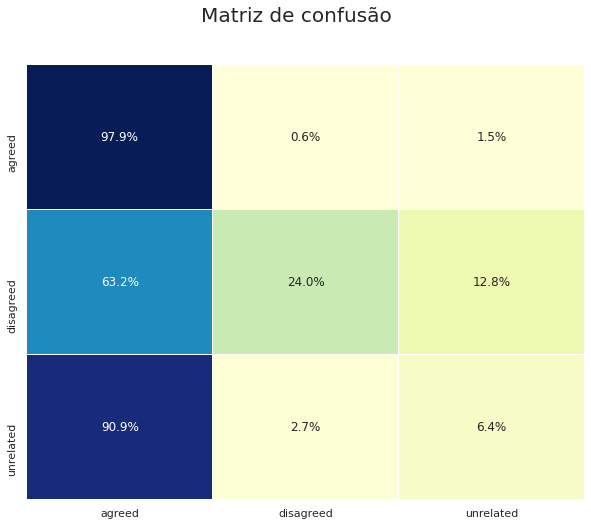

In [ ]:
evaluate(y_val, grid_clf.predict(x_val), grid_clf.predict_proba(x_val), labels=label_enc.classes_)

## Teste aplicando SMOTEEN e em seguida a Random Forest

In [ ]:
## aplicando o smoteenn
resampler = SMOTEENN()
x_train_resampled, y_train_resampled = resampler.fit_resample(x_train, y_train)


In [ ]:
# Random Forest com SMOTEENN
clf = RandomForestClassifier(       
    oob_score=True, 
    n_jobs=-1, 
    class_weight='balanced', 
    max_features=features
)

grid_clf_values = {'max_depth': [50, 100, 150], 'n_estimators': [400, 500,800]}
grid_clf = GridSearchCV(clf, param_grid = grid_clf_values, cv=3, scoring = 'balanced_accuracy', n_jobs = -1)

grid_clf.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              max_features=200, n_jobs=-1,
                                              oob_score=True, random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [50, 100, 150],
                         'n_estimators': [400, 500, 800]},
             scoring='balanced_accuracy')

In [ ]:
# Imprimindo os melhores parâmetros encontrados
print("Melhores parametros encontrados %s com score de %0.4f" % (grid_clf.best_params_, grid_clf.best_score_))

Melhores parametros encontrados {'max_depth': 150, 'n_estimators': 800} com score de 0.8640


Accuracy: 0.526
Accuracy (balanced): 0.607


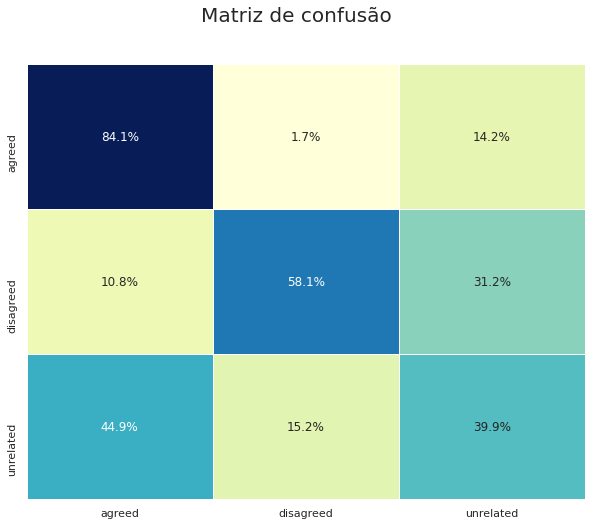

In [ ]:
evaluate(y_val, grid_clf.predict(x_val), grid_clf.predict_proba(x_val), labels=label_enc.classes_)

## Usar o counter vectorizer para calcular o número máximo de features

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(min_df=5,
							stop_words='english',
							strip_accents='unicode', 
							ngram_range=(1,3)
)


## Redes Neurais

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras import Model
from keras.layers import Dense, Activation, Input, InputLayer, Dropout
from keras import optimizers, callbacks

In [ ]:
epochs = 20
batch_size = 128
input_shape = [features]

In [ ]:
y_ohe_train = np_utils.to_categorical(ye_train, num_classes=3)
y_ohe_val = np_utils.to_categorical(ye_val, num_classes=3)

In [ ]:
model = Sequential([
InputLayer((1024,)),
Dense(1024, activation="relu"),
Dense(256, activation = "relu"),
Dense(6, activation="softmax")
])

model.compile(optimizer='sgd',
loss='categorical_crossentropy',
# metrics=['accuracy'])
metrics=['categorical_accuracy', 'top_k_categorical_accuracy'])

model.summary()



1.   Fazer tfidf usando os bigramas 
2.   Fazer o SMOTEEN antes de utilizar os classificadores
3.   Rodar novamente os classificadores 
4.   Estudar como usar o hub para classificação de sentimento em textos  https://www.tensorflow.org/tutorials/keras/text_classification_with_hub, https://tfhub.dev/google/universal-sentence-encoder/4
5.   Fazer uma rede normal
6.   Estudar redes siamesas https://keras.io/examples/vision/siamese_contrastive/

Se der tempo 
1. Estudar BERT ( arquitetura moderna para processamento ) 
    https://www.tensorflow.org/text/tutorials/classify_text_with_bert
2. https://huggingface.co/transformers/
3. Aumentação de texto https://arxiv.org/pdf/1901.11196.pdf

5.   Procurar alguma rede pronta como https://tfhub.dev/google/nnlm-en-dim128/2


Uma última dica: tem uma outra formulação para problemas de matching que nós chamamos de metric learning.
O objetivo desse tipo de aprendizado é mapear objetos não-estruturados (ex frases) em um espaço que preserve a relação de contraste entre eles (ex: frases que concordam próximas/frases que discordam distantes).
Nesse tipo de aprendizado, você tem uma rede siamesa (com duas entradas) e uma saída (se as entradas são ou não similares).
Você poderia treinar esse modelo pra identificar se duas frases concordam ou não.
Exemplo no tensorflow: https://keras.io/examples/vision/siamese_contrastive/


Links Uteis: https://www.tensorflow.org/hub/tutorials/semantic_similarity_with_tf_hub_universal_encoder

### Monitoria ideias 

max_depth melhores parametros procurar o google número magico

Utilizar novas métricas para verificar overfitting, como recall e etc. 
Exemplos : 
    matrix classification repo
    metrics.classification_report 

Ter acurácia balanceada de 0.6 já é 100% melhor que obter 1/3

Para saber o número ideial de features no tfidf :
    Fazer o counter do tfidf e plotar a distribuição de valores e importancia, 
    coletar n primeiros termos mais importantes 

O embeding serve como input do classificador 

Nas redes neurais se for usar one hot encoding utilizar como função de perda: 
    loss; categorical_crossentropy 
Se for usar a matriz normal
    sparse_categorical_crossentropy permite sem one hot encoding
    

# Teste calculando fazendo PCA no número de features

In [38]:
x_train['title_concat'] = x_train['title1_en'] + x_train['title2_en']
x_train.head()

,title1_en,title2_en,title_concat
274115,Cancer can be cured in the late stages of canc...,The state of mind determines the symptoms.,Cancer can be cured in the late stages of canc...
60912,95. High blood pressure is more than a lack of...,A week of rumours fast reading salt added anti...,95. High blood pressure is more than a lack of...
68991,"From the Beipiao girl to the star, and now ann...","""Happy Camp"" will soon stop broadcasting, Zhan...","From the Beipiao girl to the star, and now ann..."
291278,"In the details of the divorce, Cecilia Cheung ...","Experts a preference, a good treatment of the ...","In the details of the divorce, Cecilia Cheung ..."
313633,The mango tree is grafted so that the survival...,How do you prune the new moon flower?,The mango tree is grafted so that the survival...


In [39]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', strip_accents='unicode' )),
    ('clf', RandomForestClassifier(oob_score=True, n_jobs=-1, class_weight='balanced')),
])

parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__min_df': (1, 10, 100, 1000),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__max_depth': [None, 10, 20, 50],
    'clf__n_estimators': [400, 600, 800]
}
grid_search_tune = GridSearchCV(pipeline, parameters, cv=5, n_jobs=2, verbose=3)
grid_search_tune.fit(x_train['title_concat'], y_train)
print("Best parameters set:")
print(grid_search_tune.best_estimator_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

In [ ]:
print(grid_search_tune.best_params_)

{'clf__max_depth': None, 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


In [ ]:
encoder = make_pipeline(TfidfVectorizer(min_df=5,
                                        stop_words='english',
                                        strip_accents='unicode',                                        
                                        ngram_range=(1,3)),                                        
                        StandardScaler(with_mean=False))

x_train_title1 = encoder.fit_transform(x_train['title1_en']).toarray()
x_val_title1 = encoder.transform(x_val['title1_en']).toarray()

x_train_title2 = encoder.fit_transform(x_train['title2_en']).toarray()
x_val_title2 = encoder.transform(x_val['title2_en']).toarray()



In [ ]:
x_train = np.concatenate((x_train_title1, x_train_title2), axis=1)
x_val = np.concatenate((x_val_title1, x_val_title2), axis=1)

In [ ]:
x_train.shape

(7999, 8464)